In [1]:
import pandas as pd
import os
import json
import pytz
# Plotting imports
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cm
from datetime import datetime, timedelta
import numpy as np

In [2]:
# File path for the CSV (update this if needed)
file_path = './22-08-2024_NorthPLC.csv'

# Load data into DataFrame
df_torque = pd.read_csv(file_path, header=0, skiprows=22)

C:\Users\chris\AppData\Local\Temp\ipykernel_34184\348020951.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_torque = pd.read_csv(file_path, header=0, skiprows=22)


In [3]:
def torque_plot(df):
    # Create a figure
    fig, ax = plt.subplots(figsize=(15, 10))

    # Create timezone for x-axis formatting
    est = pytz.timezone('US/Eastern')
    myFmt = mdates.DateFormatter('%H:%M', tz=est)


    # Plot the torque data against the 'Unit Offset'
    ax.plot(df['Time'], df['0'], label='Torque')

    # Set x-axis formatter and labels
    ax.xaxis.set_major_formatter(myFmt)
    ax.set_xlabel('Time (HH:MM)')
    ax.set_ylabel('Torque')
    ax.set_title('Torque Over Time')

    plt.show()

In [4]:
# Step 1: Convert the 'Time' column to string (if not already)
df_torque['Unit Offset'] = df_torque['Unit Offset'].astype(str)

# Step 2: Trim whitespace
df_torque['Unit Offset'] = df_torque['Unit Offset'].str.strip()
# Step 2: Convert to numeric, coercing errors to NaN
df_torque['Unit Offset'] = pd.to_numeric(df_torque['Unit Offset'], errors='coerce')
df_torque = df_torque.dropna()

In [5]:
# Extract Starttime and Endtime from cells B3 and B4
starttime = 133688387309500000  # Example value from your image, should ideally be read programmatically if possible
endtime = 133688416054380000  # Example value from your image, should ideally be read programmatically if possible

# Convert start and end times to datetime objects (use actual date/time from your cells C3 and F3)
start_date = datetime(2024, 8, 22, 18, 18, 51, 0)
end_date = datetime(2024, 8, 22, 19, 6, 45, 45)

# Calculate the total number of seconds in the mapped datetime range
total_seconds = (end_date - start_date).total_seconds()

# Calculate time mapping factor (seconds per unit in the original timestamp)
time_per_unit = total_seconds / (endtime - starttime)

# Convert timestamps in column 1
def convert_timestamp(ts):
    # Calculate the time delta based on the original timestamp using floating-point multiplication
    time_delta_seconds = (ts - starttime) * time_per_unit

    #print(time_delta_seconds)
    # Add this delta to the start date
    return start_date + timedelta(seconds=time_delta_seconds)

#def add_time()

# Apply conversion to the first column of the DataFrame
df_torque.iloc[:, 0] = df_torque.iloc[:, 0].apply(convert_timestamp)

# Save the modified DataFrame to a new CSV file
#output_path = 'head_torque_8-22-24.csv'
#df.to_csv(output_path, index=False)

#print("Timestamps converted and data saved to", output_path)

#convert_timestamp(df_cleaned['Unit Offset'][80])

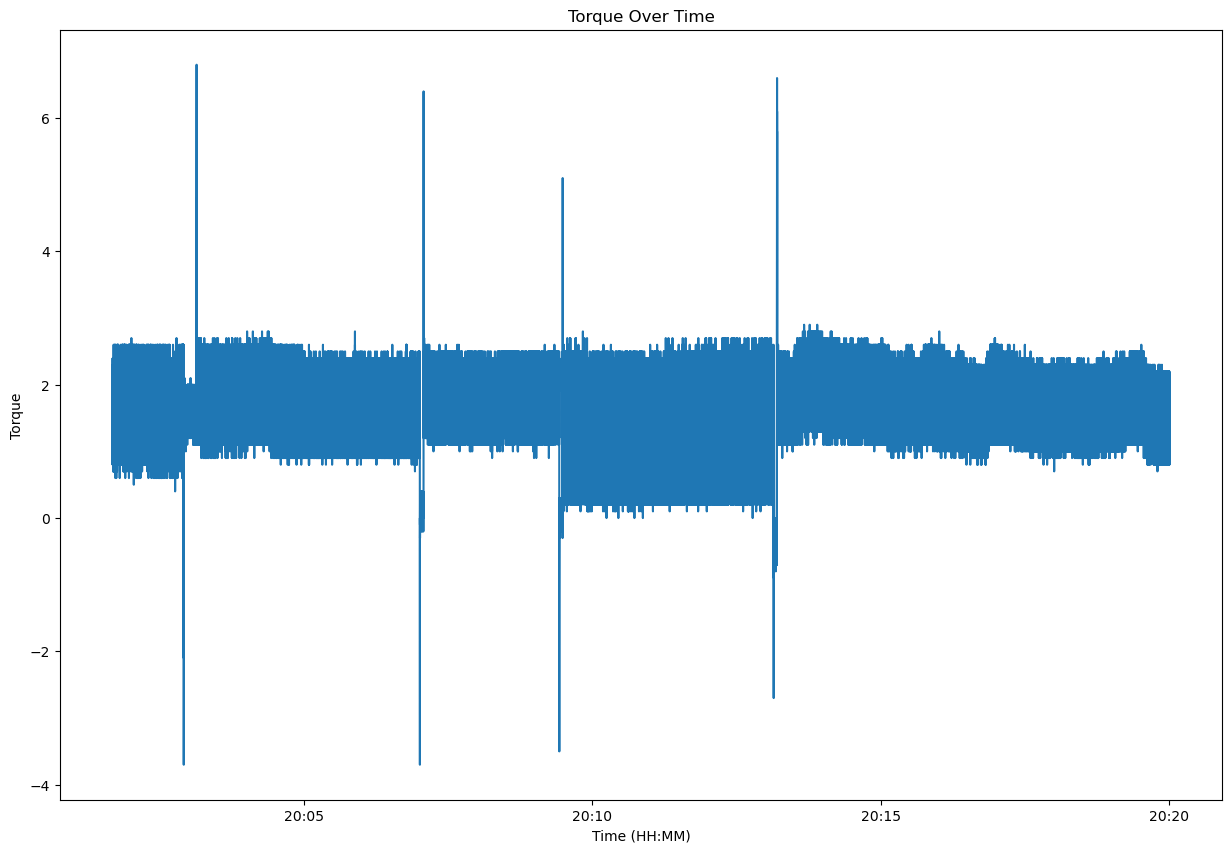

In [6]:
# Add 5 hours to the 'Time' column
df_torque['Time'] = df_torque['Unit Offset'] + pd.Timedelta(hours=5, minutes=24, seconds=30)
df_torque.reset_index(drop=True, inplace=True)
torque_plot(df_torque[1100000:2200000])

In [7]:
run_time = df_torque['Time']
torque = df_torque['0']

# Define rolling window size (adjust based on your data frequency)
window_size = 100  # Example: Rolling window of 100 samples

# Compute rolling mean and standard deviation
#rolling_mean = torque.rolling(window=window_size).mean()
#rolling_std = torque.rolling(window=window_size).std()

rolling_mean = torque.rolling(window=window_size).mean()
rolling_std = torque.rolling(window=window_size).std()

# Define upper and lower bounds of the envelope
upper_bound = rolling_mean + 3 * rolling_std  # 2-standard deviation envelope
lower_bound = rolling_mean - 3 * rolling_std

# Plot the original signal and the envelope
plt.figure(figsize=(12, 6))
plt.plot(run_time, torque, label='Torque', alpha=0.6)  # Replace 'time' with actual time column
plt.plot(run_time, rolling_mean, label='Rolling Mean (Center)', color='orange')
plt.plot(run_time, upper_bound, label='Upper Envelope', color='green', linestyle='--')
plt.plot(run_time, lower_bound, label='Lower Envelope', color='red', linestyle='--')
plt.fill_between(run_time, lower_bound, upper_bound, color='gray', alpha=0.2, label='Envelope Range')

# Customize the plot
plt.title('Torque with Envelope')
plt.xlabel('Time')
plt.ylabel('Torque')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [8]:
# Set the 'Time' column as the index
df_torque.set_index('Time', inplace=True)

In [9]:
# Resample the data at 2 Hz (0.5 seconds per sample)
resampled_data = df_torque.resample('500ms').mean()  # Resample to 2 Hz

In [10]:
resampled_data['0'] = resampled_data['0'].interpolate(method='linear')  # Interpolate missing values

In [11]:
# Define rolling window size (adjust based on new frequency)
window_size = 128  # Example: Rolling window of 20 samples for 2 Hz data

# Compute rolling mean and standard deviation
rolling_mean = resampled_data['0'].rolling(window=window_size).mean()
rolling_std = resampled_data['0'].rolling(window=window_size).std()

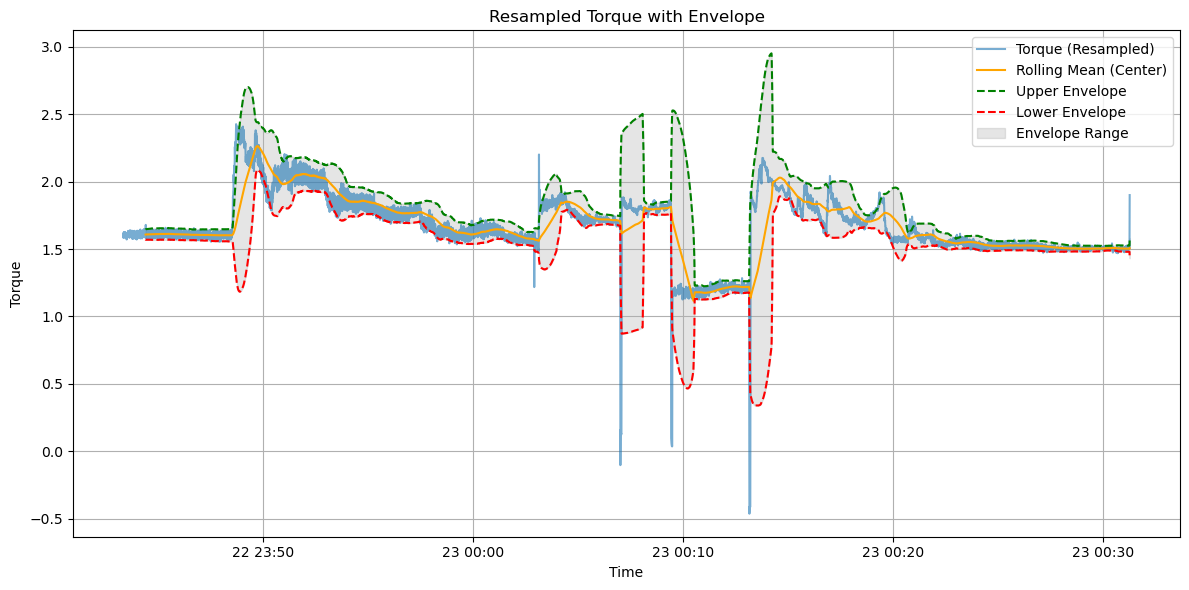

In [12]:
# Define upper and lower bounds of the envelope
upper_bound = rolling_mean + 2 * rolling_std  # 2-standard deviation envelope
lower_bound = rolling_mean - 2 * rolling_std

# Plot the resampled signal and envelope
plt.figure(figsize=(12, 6))
plt.plot(resampled_data.index, resampled_data['0'], label='Torque (Resampled)', alpha=0.6)
plt.plot(resampled_data.index, rolling_mean, label='Rolling Mean (Center)', color='orange')
plt.plot(resampled_data.index, upper_bound, label='Upper Envelope', color='green', linestyle='--')
plt.plot(resampled_data.index, lower_bound, label='Lower Envelope', color='red', linestyle='--')
plt.fill_between(resampled_data.index, lower_bound, upper_bound, color='gray', alpha=0.2, label='Envelope Range')

# Customize the plot
plt.title('Resampled Torque with Envelope')
plt.xlabel('Time')
plt.ylabel('Torque')
plt.legend()
plt.grid()
plt.tight_layout()

In [13]:
# Define rolling window size (adjust based on new frequency)
window_size = 128  # Example: Rolling window of 20 samples for 2 Hz data

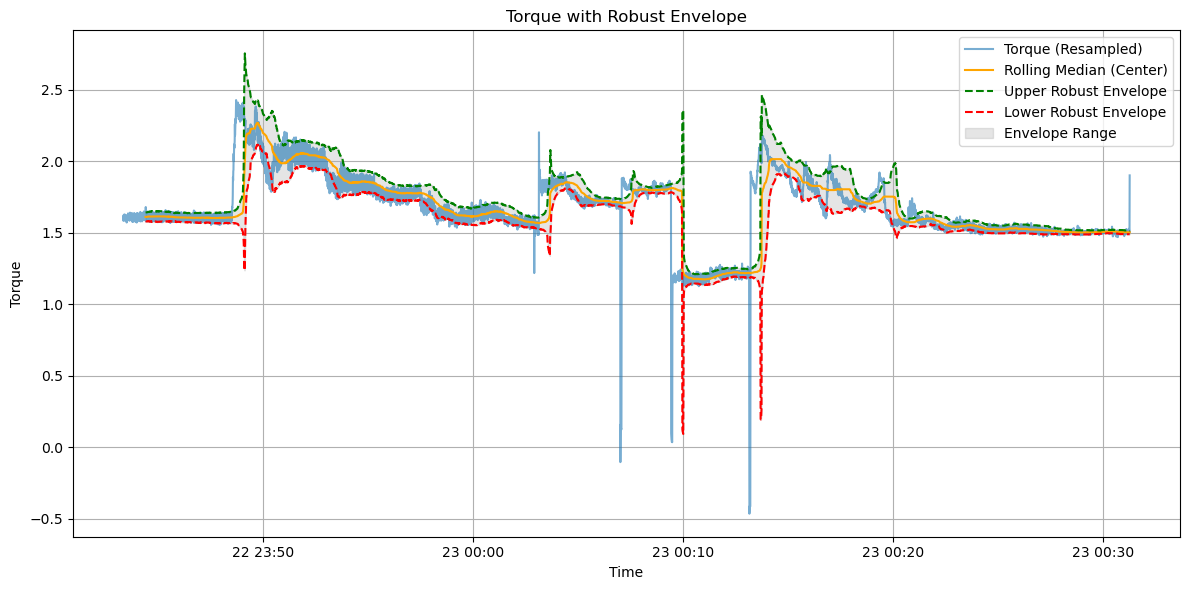

In [14]:
# Compute the rolling median
rolling_median = resampled_data['0'].rolling(window=window_size).median()

# Compute the Median Absolute Deviation (MAD)
def rolling_mad(series, window):
    return series.rolling(window=window).apply(lambda x: np.median(np.abs(x - np.median(x))), raw=True)

rolling_mad_value = rolling_mad(resampled_data['0'], window_size)

# Define upper and lower bounds using the rolling MAD
#k = 1.482  # Scaling factor to approximate standard deviation
k = 2
upper_bound = rolling_median + k * rolling_mad_value
lower_bound = rolling_median - k * rolling_mad_value

# Plot the resampled signal and robust envelope
plt.figure(figsize=(12, 6))
plt.plot(resampled_data.index, resampled_data['0'], label='Torque (Resampled)', alpha=0.6)
plt.plot(resampled_data.index, rolling_median, label='Rolling Median (Center)', color='orange')
plt.plot(resampled_data.index, upper_bound, label='Upper Robust Envelope', color='green', linestyle='--')
plt.plot(resampled_data.index, lower_bound, label='Lower Robust Envelope', color='red', linestyle='--')
plt.fill_between(resampled_data.index, lower_bound, upper_bound, color='gray', alpha=0.2, label='Envelope Range')

# Customize the plot
plt.title('Torque with Robust Envelope')
plt.xlabel('Time')
plt.ylabel('Torque')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

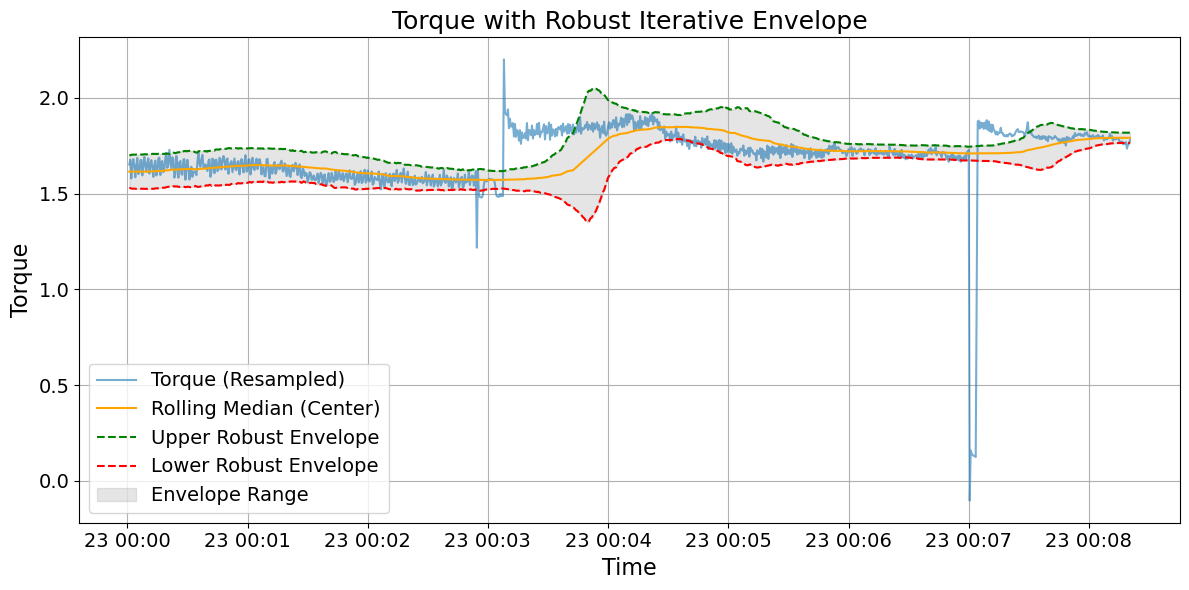

In [17]:
# Function to iteratively filter outliers and calculate robust bounds
def calculate_robust_envelope(series, window, threshold=2):
    rolling_median = series.rolling(window=window).median()
    mad = series.rolling(window=window).apply(lambda x: np.median(np.abs(x - np.median(x))), raw=True)
    k = 1.482  # Scaling factor to approximate standard deviation
    
    upper_bound = rolling_median + threshold * k * mad
    lower_bound = rolling_median - threshold * k * mad

    # Exclude points outside the envelope and recalculate
    filtered_series = series.copy()
    for i in range(len(series)):
        if i >= window - 1:  # Only filter after enough points for a full window
            window_values = filtered_series.iloc[max(0, i - window + 1):i + 1]
            median = rolling_median.iloc[i]
            mad_value = mad.iloc[i]
            upper_limit = median + threshold * k * mad_value
            lower_limit = median - threshold * k * mad_value

            # Replace outliers with NaN (effectively removing them from the window)
            if not (lower_limit <= series.iloc[i] <= upper_limit):
                filtered_series.iloc[i] = np.nan

    # Interpolate removed points for final envelope calculation
    filtered_series = filtered_series.interpolate(method='linear')
    final_rolling_median = filtered_series.rolling(window=window).median()
    final_mad = filtered_series.rolling(window=window).apply(lambda x: np.median(np.abs(x - np.median(x))), raw=True)

    upper_final = final_rolling_median + threshold * k * final_mad
    lower_final = final_rolling_median - threshold * k * final_mad

    return final_rolling_median, upper_final, lower_final

# Calculate the robust envelope
rolling_median, upper_bound, lower_bound = calculate_robust_envelope(resampled_data['0'], window_size)

period_up = 2000
period_down = 3000

# Plot the resampled signal and robust envelope
plt.figure(figsize=(12, 6))
plt.plot(resampled_data.index[period_up:period_down], resampled_data['0'][period_up:period_down], label='Torque (Resampled)', alpha=0.6)
plt.plot(resampled_data.index[period_up:period_down], rolling_median[period_up:period_down], label='Rolling Median (Center)', color='orange')
plt.plot(resampled_data.index[period_up:period_down], upper_bound[period_up:period_down], label='Upper Robust Envelope', color='green', linestyle='--')
plt.plot(resampled_data.index[period_up:period_down], lower_bound[period_up:period_down], label='Lower Robust Envelope', color='red', linestyle='--')
plt.fill_between(resampled_data.index[period_up:period_down], lower_bound[period_up:period_down], upper_bound[period_up:period_down], color='gray', alpha=0.2, label='Envelope Range')

text_size = 16

# Customize the plot
plt.title('Torque with Robust Iterative Envelope', fontsize=text_size+2)
plt.xlabel('Time', fontsize=text_size)
plt.ylabel('Torque', fontsize=text_size)
plt.legend(fontsize=text_size-2)
plt.xticks(fontsize=text_size-2)
plt.yticks(fontsize=text_size-2)
plt.grid()
plt.tight_layout()
plt.savefig('plot_high_res.png', dpi=300, bbox_inches='tight')
plt.show()

In [16]:
plt.savefig('plot.jpg')  # Saves as 'plot.pdf'

<Figure size 640x480 with 0 Axes>